In [1]:
import logging
import os
import sys
import multiprocessing
import gensim 
from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

from sklearn.manifold import TSNE
from sklearn.cluster import AffinityPropagation, DBSCAN, AgglomerativeClustering, MiniBatchKMeans
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 15.0)

Couldn't import dot_parser, loading of dot files will not be possible.


Using cuDNN version 5103 on context None
Mapped name None to device cuda: Quadro K4200 (0000:08:00.0)


In [2]:
path_io_files = '../../datasets/Word2Vec/'

### Base Google News

In [3]:
#http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/
googlenews = os.path.join(path_io_files,'GoogleNews-vectors-negative300.bin.gz')
questions = os.path.join(path_io_files,'questions-words.txt')

In [4]:
model_googlenews = gensim.models.Word2Vec.load_word2vec_format(googlenews, binary=True)

In [5]:
evals = open(questions, 'r').readlines()
num_sections = len([l for l in evals if l.startswith(':')])
print('total evaluation sentences: {} '.format(len(evals) - num_sections))

total evaluation sentences: 19544 


In [10]:
def w2v_model_accuracy(model):
    accuracy = model.accuracy(questions)
    sum_corr = len(accuracy[-1]['correct'])
    sum_incorr = len(accuracy[-1]['incorrect'])
    total = sum_corr + sum_incorr
    percent = lambda a: a / total * 100
    print('Total sentences: {}, Correct: {:.2f}%, Incorrect: {:.2f}%'.format(total, 
                                                                             percent(sum_corr), 
                                                                             percent(sum_incorr)))

In [11]:
w2v_model_accuracy(model_googlenews)

Total sentences: 13190, Correct: 77.08%, Incorrect: 22.92%


In [12]:
model_googlenews.most_similar("queen")

[('queens', 0.7399442195892334),
 ('princess', 0.7070531845092773),
 ('king', 0.6510956883430481),
 ('monarch', 0.6383601427078247),
 ('very_pampered_McElhatton', 0.6357026696205139),
 ('Queen', 0.6163408756256104),
 ('NYC_anglophiles_aflutter', 0.6060680150985718),
 ('Queen_Consort', 0.592379629611969),
 ('princesses', 0.5908075571060181),
 ('royal', 0.5637185573577881)]

### Base Media Cloud

In [13]:
#mediacloud = os.path.join(path_io_files, 'MediaCloud_w2v')
mediacloud = os.path.join(path_io_files, 'MediaCloud_w2v_trigrams')

In [14]:
model_mediacloud = gensim.models.Word2Vec.load(mediacloud)

In [15]:
model_mediacloud.most_similar('fgv')

[('fundação_getúlio', 0.7404108047485352),
 ('vargas_fgv', 0.7010539770126343),
 ('fundação_getulio', 0.7001169323921204),
 ('ibre', 0.6558458209037781),
 ('eesp', 0.6423794031143188),
 ('getulio_vargas', 0.6356330513954163),
 ('eaesp', 0.628360390663147),
 ('economia_ibre', 0.625259518623352),
 ('economia_fundação', 0.6108883619308472),
 ('ibre_fgv', 0.6033610701560974)]

In [16]:
def build_neighbors(word, model, nviz=15):
    g = nx.Graph()
    g.add_node(word, {'color':'blue'})
    viz1 = model.most_similar(word, topn=nviz)
    g.add_weighted_edges_from([(word, v, w) for v,w in viz1 if w> 0.5] )
    for v in viz1:
        g.add_weighted_edges_from([(v[0], v2, w2) for v2,w2 in model.most_similar(v[0])])
    return g

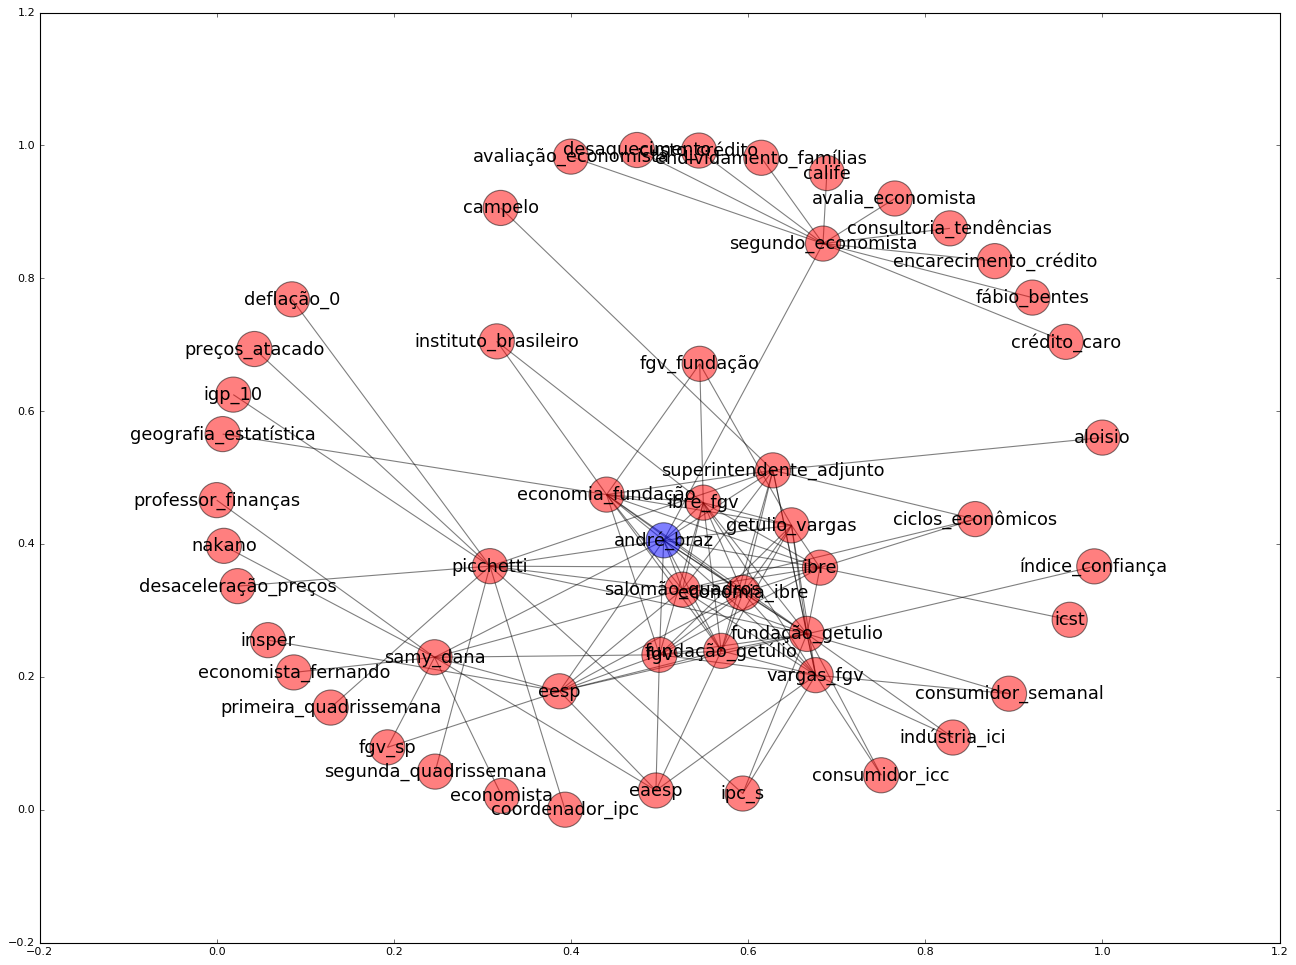

In [17]:
word = 'andré_braz'
g = build_neighbors(word, model_mediacloud)
cols = ['r']*len(g.nodes()); cols[g.nodes().index(word)]='b'
pos = nx.spring_layout(g, iterations=100)
nx.draw_networkx(g,pos=pos, node_color=cols, node_size=1000, alpha=0.5, font_size=16)
#nx.draw_networkx_labels(g, pos,dict(zip(g.nodes(),g.nodes())))

### Base Wikipedia